## Part 1

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

1. Load and resize an image using OpenCV's `imread()` and `resize()` functions.
2. Blur the resized image using OpenCV's `GaussianBlur()` function.
3. Detect edges in the blurred image using OpenCV's `Canny()` function.
4. Define a polygonal mask to apply to the edges using NumPy's `array()` function to define the vertices of the polygon and OpenCV's `fillPoly()` function to create a binary mask.
5. Apply the mask to the edges using OpenCV's `bitwise_and()` function.
6. Create an overlay of the resized image to act as a background for the final output.
7. Draw the polygonal mask onto the overlay using OpenCV's `polylines()` function.
8. Display the original resized image, the original image with the mask applied, and the edges both with and without the mask using Matplotlib's `imshow()` function and `subplots()` function to create a grid of images.

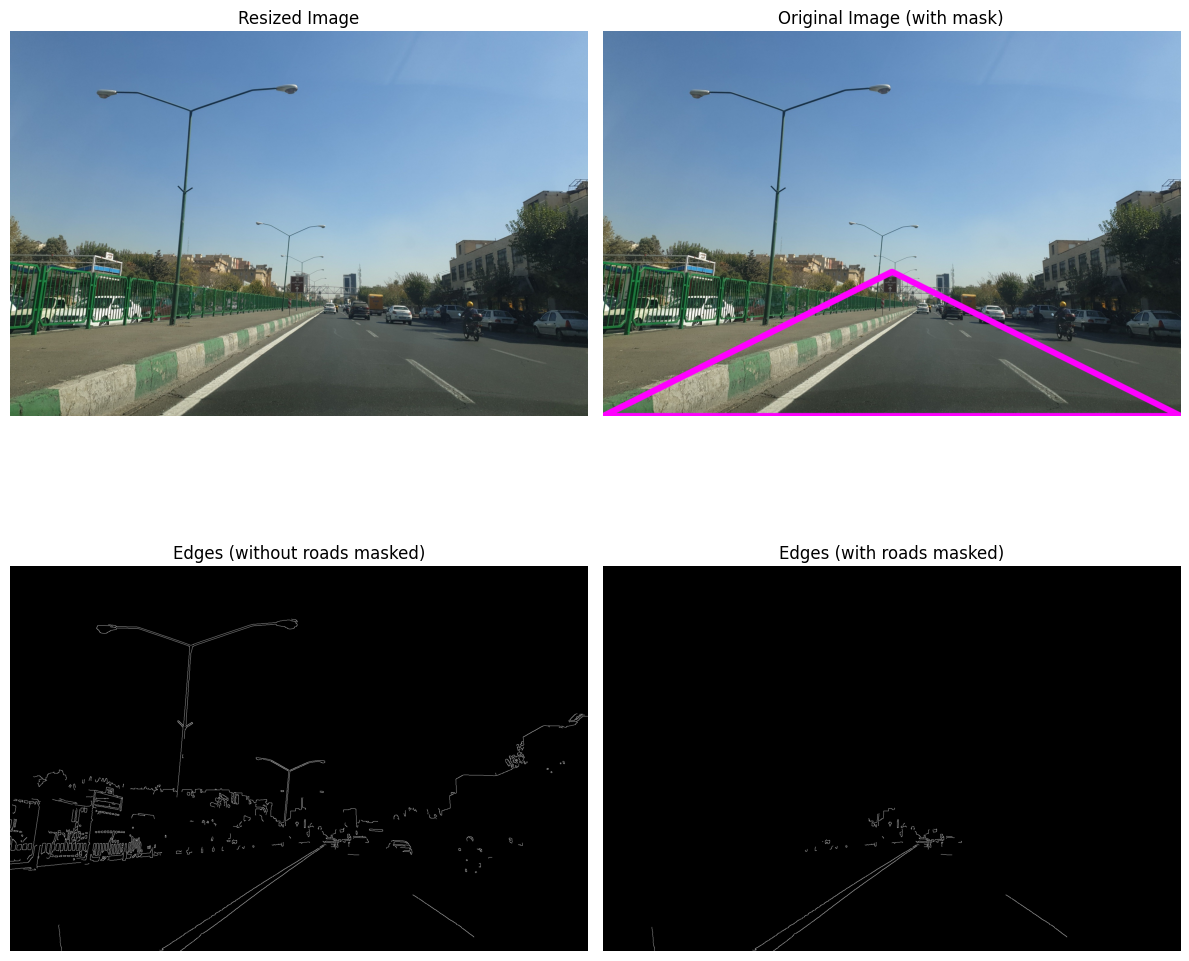

In [ ]:
img = cv2.imread("img1.jpg")

height, width, _ = img.shape
aspect_ratio = height / width
height = int(width * aspect_ratio)
img_resized = cv2.resize(img, (width, height))
img_resized = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

img_blur = cv2.GaussianBlur(img_resized, (7, 7), 0)
edges = cv2.Canny(img_blur, 120, 210)
vertices = np.array([[(0, height), (width/2, height/2 + height/8), (width, height)]], dtype=np.int32)
mask = np.zeros_like(edges)

cv2.fillPoly(mask, vertices, 255)
masked_edges = cv2.bitwise_and(edges, mask)
overlay = img_resized.copy()
cv2.polylines(overlay, vertices, True, (255, 0, 255), thickness=20)

fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs[0, 0].imshow(img_resized)
axs[0, 0].set_title('Resized Image')
axs[0, 0].axis('off')

axs[0, 1].imshow(overlay)
axs[0, 1].set_title('Original Image (with mask)')
axs[0, 1].axis('off')

axs[1, 0].imshow(edges, cmap='gray')
axs[1, 0].set_title('Edges (without roads masked)')
axs[1, 0].axis('off')

axs[1, 1].imshow(masked_edges, cmap='gray')
axs[1, 1].set_title('Edges (with roads masked)')
axs[1, 1].axis('off')

plt.tight_layout()
plt.show()

## Part 2

1. Apply the Canny edge detection algorithm to the blurred image with the previously defined mask applied.
2. Detect lines in the resulting edge image using the Hough transform with OpenCV's `HoughLinesP()` function. The function parameters control the sensitivity of the algorithm and the minimum length and maximum gap between line segments to be considered part of the same line.
3. Create a new image of the same size as the original image with all pixels set to zero using NumPy's `zeros_like()` function.
4. Draw the detected lines onto the new image using OpenCV's `line()` function.
5. Combine the original resized image with the line image using OpenCV's `addWeighted()` function, which applies a weighted sum of the two images. This creates a final image with the lines overlaid on the original image with some transparency.
6. Display the final image using Matplotlib's `imshow()` function.

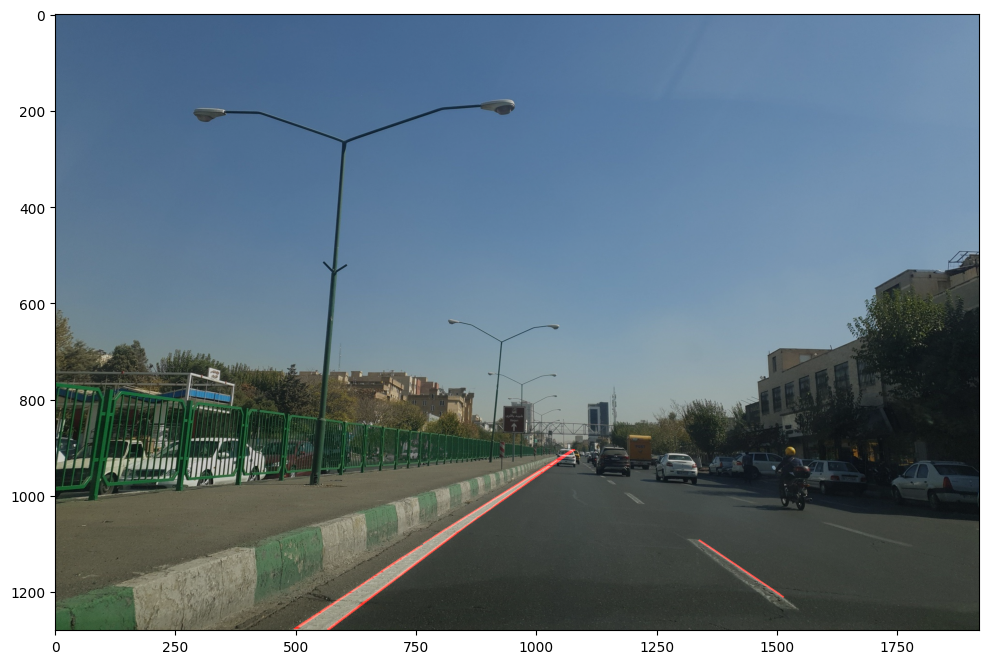

In [ ]:
# lines = cv2.HoughLinesP(masked_edges, rho=1, theta=np.pi/180, threshold=40, minLineLength=50, maxLineGap=10)
# lines = cv2.HoughLinesP(masked_edges, rho=1, theta=np.pi/180, threshold=75, minLineLength=90, maxLineGap=40)
lines = cv2.HoughLinesP(masked_edges, rho=1, theta=np.pi/180, threshold=75, minLineLength=150, maxLineGap=45)
line_img = np.zeros_like(img_resized)
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(line_img, (x1, y1), (x2, y2), (255, 0, 0), 2)

final_img = cv2.addWeighted(img_resized, 0.8, line_img, 1, 0)

fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(final_img, cmap='gray')
plt.show()

## Part 3

1. Separate the Hough lines into left and right groups based on their slope. Lines with negative slopes are assigned to the left group, and lines with positive slopes are assigned to the right group.
2. Calculate the weighted average slope and intercept for each lane by taking into account the length of each line.
3. Define the y coordinates for the bottom and top of the lane lines based on the height of the image.
4. Calculate the x coordinates for the bottom and top of each lane line using the weighted average slope and intercept, as well as the y coordinates defined in step 3.
5. Draw the left and right lane lines on a new image using OpenCV's `line()` function. If no lines are present for a given lane, no line will be drawn.
6. Combine the original resized image with the lane line image using OpenCV's `addWeighted()` function, which applies a weighted sum of the two images. This creates a final image with the lane lines overlaid on the original image with some transparency.
7. Display the final image using Matplotlib's `imshow()` function.

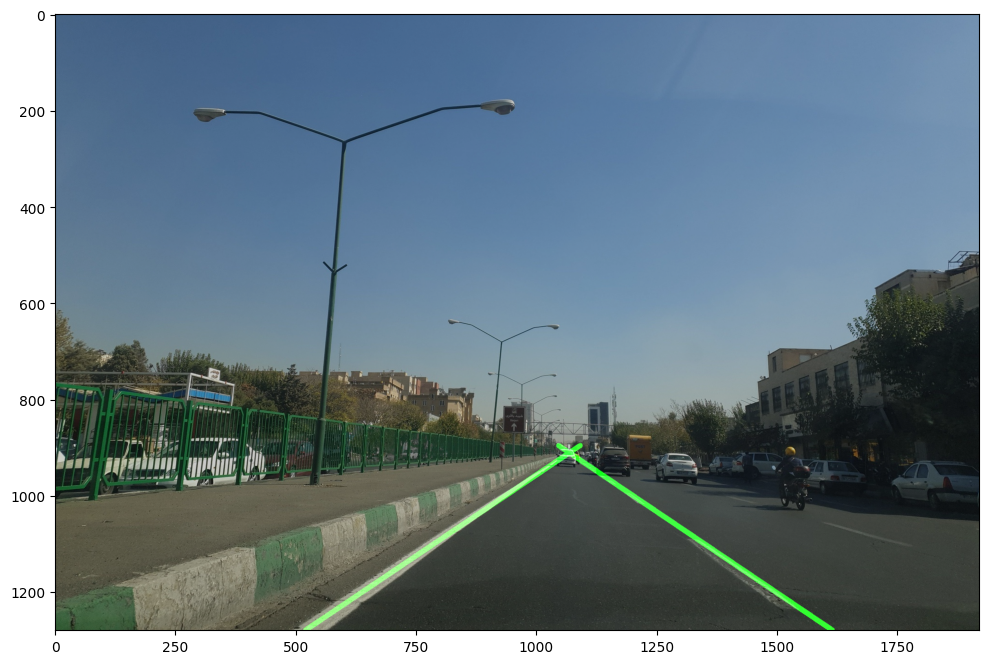

In [ ]:
# separate the hough lines into left and right groups based on their slope
left_lines = []
right_lines = []
for line in lines:
    x1, y1, x2, y2 = line[0]
    slope = (y2 - y1) / (x2 - x1)
    if slope < 0:
        left_lines.append((x1, y1, x2, y2))
    else:
        right_lines.append((x1, y1, x2, y2))

# calculate the weighted average slope and intercept for each lane
left_slope, left_intercept, left_weight = 0, 0, 0
for line in left_lines:
    x1, y1, x2, y2 = line
    length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    left_slope += slope * length
    left_intercept += (y1 - slope * x1) * length
    left_weight += length
if left_weight > 0:
    left_slope /= left_weight
    left_intercept /= left_weight

right_slope, right_intercept, right_weight = 0, 0, 0
for line in right_lines:
    x1, y1, x2, y2 = line
    length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    slope = (y2 - y1) / (x2 - x1)
    right_slope += slope * length
    right_intercept += (y1 - slope * x1) * length
    right_weight += length
if right_weight > 0:
    right_slope /= right_weight
    right_intercept /= right_weight

# define the y coordinates for the bottom and top of the lane lines
y_bottom = img_resized.shape[0]
y_top = int(y_bottom * 0.7)

# calculate the x coordinates for the bottom and top of the lane lines
if left_weight > 0:
    x_left_bottom = int((y_bottom - left_intercept) / left_slope)
    x_left_top = int((y_top - left_intercept) / left_slope)
else:
    x_left_bottom, x_left_top = 0, 0
if right_weight > 0:
    x_right_bottom = int((y_bottom - right_intercept) / right_slope)
    x_right_top = int((y_top - right_intercept) / right_slope)
else:
    x_right_bottom, x_right_top = 0, 0

# draw the lane lines on the original image
line_img = np.zeros_like(img_resized)
if left_weight > 0:
    cv2.line(line_img, (x_left_bottom, y_bottom), (x_left_top, y_top), (0, 255, 0), 10)
if right_weight > 0:
    cv2.line(line_img, (x_right_bottom, y_bottom), (x_right_top, y_top), (0, 255, 0), 10)
final_imgg = cv2.addWeighted(img_resized, 0.8, line_img, 1, 0)

fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(final_imgg, cmap='gray')
plt.show()

# Part 4

1. Define several functions for processing the input video frames, including edge detection using the Canny algorithm, region of interest cropping, Hough line detection, and averaging of the detected lines to produce a single left and right lane line.
2. Define a function to apply a Contrast Limited Adaptive Histogram Equalization (CLAHE) filter to the input image to enhance visibility in hazy conditions.
3. Open the input video file and extract its properties, such as width, height, frame count, and frames per second.
4. Define the output video file using the same width, height, and fps as the input video.
5. Loop through each frame in the input video and apply the processing steps defined in steps 1 and 2 to detect and draw the lane lines on the frame.
6. Write the processed frame to the output video file.
7. Exit the loop when all frames have been processed or the user presses the 'q' key.
8. Release the input and output video files and destroy any remaining windows.

In [ ]:
def canny(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    canny = cv2.Canny(blur, 50, 80)

    return canny

def region_of_interest(image):
    height = image.shape[0]
    width = image.shape[1]
    vertices = np.array([[(0, height), (width/2, height/2), (width, height)]], dtype=np.int32)
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, vertices, 255)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

def display_lines(image, lines):
    line_image = np.zeros_like(image)
    if lines is not None:
        for line in lines:
            if line is not None:
                x1, y1, x2, y2 = line.reshape(4)
                cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 15)
    return line_image

def make_coordinates(image, line_parameters):
    slope, intercept = line_parameters
    y1 = image.shape[0]
    y2 = int(y1 * (3/5))
    x1 = int((y1 - intercept) / slope)
    x2 = int((y2 - intercept) / slope)
    return np.array([x1, y1, x2, y2])

def average_slope_intercept(image, lines):
    left_fit = []
    right_fit = []
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        parameters = np.polyfit((x1, x2), (y1, y2), 1)
        slope = parameters[0]
        intercept = parameters[1]
        if slope < 0:
            left_fit.append((slope, intercept))
        else:
            right_fit.append((slope, intercept))
    left_fit_average = np.average(left_fit, axis=0) if len(left_fit) > 0 else None
    right_fit_average = np.average(right_fit, axis=0) if len(right_fit) > 0 else None

    left_line = make_coordinates(image, left_fit_average) if left_fit_average is not None else None
    right_line = make_coordinates(image, right_fit_average) if right_fit_average is not None else None
    return np.array([left_line, right_line])

def apply_clahe(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    lab_planes = cv2.split(lab)
    lab_planes = list(lab_planes)
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab_planes = tuple(lab_planes)
    lab = cv2.merge(lab_planes)
    return cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)


In [ ]:

# video_name = 'vid1.mp4'
video_name = 'vid2.mp4'

cap = cv2.VideoCapture(video_name)

fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Define output video file
out = cv2.VideoWriter('output_vid_2.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))
print(f'{frame_count = }')

while(cap.isOpened()):
    # Read a frame
    ret, frame = cap.read()
    if not ret:
        break

    if video_name == 'vid2.mp4':
        # apply CLAHE filter for haze conditions
        frame = apply_clahe(frame)

    # Detect lanes
    canny_image = canny(frame)
    cropped_image = region_of_interest(canny_image)

    if video_name == 'vid2.mp4':
        # vid 2 with CLAHE / votes = 70-60
        lines = cv2.HoughLinesP(cropped_image, 2, np.pi/180, 65, np.array([]), minLineLength=30, maxLineGap=45)
    else:
        # vid 1 / votes = 100-120 best = 110
        lines = cv2.HoughLinesP(cropped_image, 2, np.pi/180, 110, np.array([]), minLineLength=30, maxLineGap=45)

    if lines is not None:
        averaged_lines = average_slope_intercept(frame, lines)
        line_image = display_lines(frame, averaged_lines)
        combo_image = cv2.addWeighted(frame, 0.7, line_image, 1, 1)
    else:
        combo_image = frame

    out.write(combo_image)

    if cv2.waitKey(1) == ord('q'):
        break

cap.release()
out.release()
cv2.destroyAllWindows()

frame_count = 319


<ipython-input-13-6e89b2346518>:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([left_line, right_line])
